In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mikiask/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
raw_analysis = pd.read_csv('../data/raw_analyst_ratings.csv')


**Checking for null variables**

In [3]:
raw_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1407328 non-null  int64 
 1   headline    1407328 non-null  object
 2   url         1407328 non-null  object
 3   publisher   1407328 non-null  object
 4   date        1407328 non-null  object
 5   stock       1407328 non-null  object
dtypes: int64(1), object(5)
memory usage: 64.4+ MB


In [ ]:
raw_analysis['date'].head()


0    2020-06-05 10:30:54-04:00
1    2020-06-03 10:45:20-04:00
2    2020-05-26 04:30:07-04:00
3    2020-05-22 12:45:06-04:00
4    2020-05-22 11:38:59-04:00
Name: date, dtype: object

**Convert object to datetime** 

In [ ]:
raw_analysis['date'] = pd.to_datetime(raw_analysis['date'], format='%Y-%M',utc=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype              
---  ------      --------------    -----              
 0   Unnamed: 0  1407328 non-null  int64              
 1   headline    1407328 non-null  object             
 2   url         1407328 non-null  object             
 3   publisher   1407328 non-null  object             
 4   date        1407328 non-null  datetime64[ns, UTC]
 5   stock       1407328 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(1), object(4)
memory usage: 64.4+ MB


0     2020-06-05 14:30:54+00:00
1     2020-06-03 14:45:20+00:00
2     2020-05-26 08:30:07+00:00
3     2020-05-22 16:45:06+00:00
4     2020-05-22 15:38:59+00:00
                 ...           
195   2018-05-18 00:00:00+00:00
196   2018-05-16 00:00:00+00:00
197   2018-05-15 00:00:00+00:00
198   2018-05-15 00:00:00+00:00
199   2018-05-15 00:00:00+00:00
Name: date, Length: 200, dtype: datetime64[ns, UTC]

In [13]:
# count headline length
raw_analysis['headline_length'] = raw_analysis['headline'].str.len()

In [23]:
# count each publisher published articles
publisher_counts = raw_analysis['publisher'].value_counts()
publisher_counts.head(20)

publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Vick Meyer            24826
webmaster             20313
Benzinga_Newsdesk     19410
Zacks                 19390
Jayson Derrick        19050
Allie Wickman         18317
Shanthi Rexaline      16640
Craig Jones           16221
Wayne Duggan          12897
Nelson Hem            12590
Name: count, dtype: int64

date
2009-02-28 00:00:00+00:00       1
2009-03-31 00:00:00+00:00       0
2009-04-30 00:00:00+00:00       3
2009-05-31 00:00:00+00:00      12
2009-06-30 00:00:00+00:00      40
2009-07-31 00:00:00+00:00      75
2009-08-31 00:00:00+00:00    3633
2009-09-30 00:00:00+00:00    1023
2009-10-31 00:00:00+00:00    1330
2009-11-30 00:00:00+00:00    2262
Freq: ME, dtype: int64


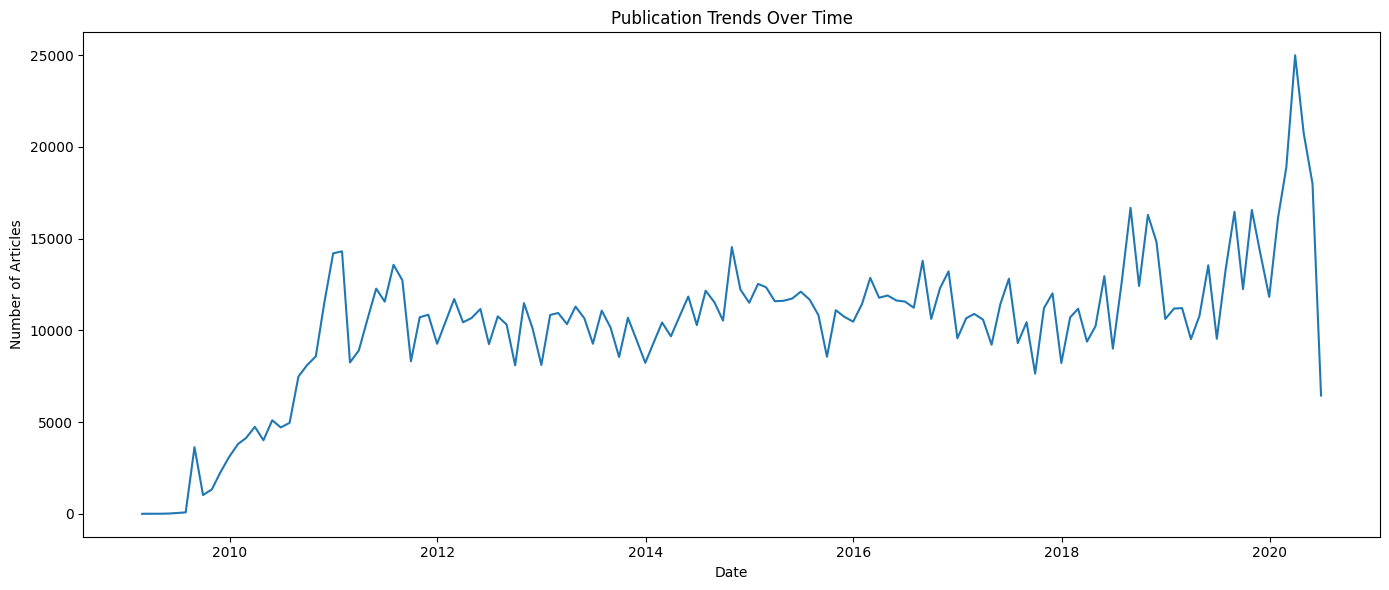

In [38]:


# Group by date (e.g., by month) and count articles
monthly_counts = raw_analysis.set_index('date').resample('ME').size()
print(monthly_counts.head(10))
plt.figure(figsize=(14, 6))
sns.lineplot(x=monthly_counts.index, y=monthly_counts.values)
plt.title('Publication Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.tight_layout()
plt.show()


### Topic Modeling

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Preprocess headlines: remove stopwords and tokenize
stop_words = set(stopwords.words('english'))
def preprocess(text):
    tokens = word_tokenize(str(text).lower())
    
    return ' '.join([word for word in tokens if word.isalpha() and word not in stop_words])

raw_analysis['processed_headline'] = raw_analysis['headline'].apply(preprocess)

# Vectorize the processed headlines
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
headline_matrix = vectorizer.fit_transform(raw_analysis['processed_headline'])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(headline_matrix)

# Display top words for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()

print_top_words(lda, vectorizer.get_feature_names_out(), 10)